In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

# extractor = SuperPoint(max_num_keypoints=256).eval().to(device)  # load the extractor
# matcher = LightGlue(features="superpoint").eval().to(device)

In [3]:
def extract_patches(image, keypoints, size=64):
    patches = []
    valid_keypoints = []  # To store keypoints for which patches are created

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            continue  # Skip if the patch would be out of image bounds

        # Extract patch and store the corresponding keypoint
        patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        patches.append(patch)
        valid_keypoints.append((x, y))

    return patches, valid_keypoints

In [4]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# from siamese.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [6]:
class UNet(nn.Module):
    def __init__(self, output_size=128):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)  # Output: 64x64x128
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 32x32x256
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16x256
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 8x8x512
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)  # Output: 4x4x1024
        # Decoder with dense layers for embedding
        self.fc1 = nn.Linear(512 * 2 * 2, output_size)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = self.max_pool(x)
        x = F.relu(self.enc_conv3(x))
        x = self.max_pool(x)
        x = F.relu(self.enc_conv4(x))

        # Flatten for the fully connected layers
        x = x.view(x.size(0), -1)

        # Decoder with dense layers for embedding
        x = self.fc1(x)

        return x


# class UNet(nn.Module):
#     def __init__(self, output_size=128):
#         super(UNet, self).__init__()

#         self.network = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             #256x256x64
#             nn.Conv2d(64, 128, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=128),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #128x128x128
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding='valid'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=256),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #64x64x256
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding='valid'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #32x32x512
#             nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding="valid"),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=1024),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #16x16x1024
#             nn.Conv2d(1024, 512, kernel_size=3, stride=2, padding="valid"),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #8x8x512
#             nn.Conv2d(512, 256, kernel_size=3, stride=2, padding="valid"),
#             nn.ReLU(),

#             nn.Conv2d(256, 128, kernel_size=3, padding="same"),
#             nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #4x4x256
#             # nn.Conv2d(256, 128, kernel_size=2, padding="same"),
#             # nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             # 2x2x128 
#             nn.Flatten(),
#             nn.Linear(128*3*3, 128)
#             # nn.Conv2d(128, 128, kernel_size=1, stride=1),
#             # nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = self.network(x)
#         return x

# class UNet(nn.Module):
    
#     def __init__(self, output_size=128):
#         super(UNet, self).__init__()

#         self.network = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             #256x256x64
#             nn.Conv2d(64, 128, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=128),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             #128x128x128
#             nn.Conv2d(128, 256, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=256),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             #64x64x256
#             nn.Conv2d(256, 512, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             #32x32x512
#             nn.Conv2d(512, 1024, kernel_size=3, padding="same"),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=1024),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             #16x16x1024
#             nn.Conv2d(1024, 512, kernel_size=3, padding="same"),
#             nn.ReLU(),
#             # WaveletPool2d(wavelet='haar', mode='zero', channels=512),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             #8x8x512
#             nn.Conv2d(512, 256, kernel_size=3, padding="same"),
#             nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             #4x4x256
#             # nn.Conv2d(256, 128, kernel_size=2, padding="same"),
#             # nn.ReLU(),
#             # nn.MaxPool2d(kernel_size=2, stride=2),
#             # 2x2x128 
#             nn.Flatten(),
#             nn.Linear(256*4*4, 128)
#             # nn.Conv2d(128, 128, kernel_size=1, stride=1),
#             # nn.Sigmoid(),
#         )
    
#     def forward(self, x):
#         x = self.network(x)
#         return x

# class UNet(nn.Module):
#     def __init__(self, output_size=128):
#         super(UNet, self).__init__()

#         # Encoder
#         self.enc_conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1)  # Output: 64x64x128
#         self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 32x32x256
#         self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16x256
#         self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # Output: 8x8x512
#         self.enc_conv4 = nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=0)  # Output: 4x4x1024
#         # Decoder with dense layers for embedding
#         self.fc1 = nn.Linear(1024 * 4 * 4, output_size)

#     def forward(self, x):
#         # Encoder
#         x = F.relu(self.enc_conv1(x))
#         x = F.relu(self.enc_conv2(x))
#         x = self.max_pool(x)
#         x = F.relu(self.enc_conv3(x))
#         x = self.max_pool(x)
#         x = F.relu(self.enc_conv4(x))

#         # Flatten for the fully connected layers
#         x = x.view(x.size(0), -1)

#         # Decoder with dense layers for embedding
#         x = self.fc1(x)

#         return x

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.get_embedding(x1)
        output2 = self.get_embedding(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


In [8]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
embedding_net = UNet().to(device)
model = SiameseNetwork(embedding_net).to(device)
print(model)

cuda
SiameseNetwork(
  (embedding_net): UNet(
    (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_conv4): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (fc1): Linear(in_features=2048, out_features=128, bias=True)
  )
)


In [9]:
model_state_file = "model_weights-mr_us-64_256-case096-inv.pth"
model.load_state_dict(torch.load(model_state_file, map_location=torch.device('cpu')))
model.eval()

SiameseNetwork(
  (embedding_net): UNet(
    (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (enc_conv4): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (fc1): Linear(in_features=2048, out_features=128, bias=True)
  )
)

In [10]:
def convert_to_displayable_image(image):
    # Convert from tensor to NumPy if needed
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    # If image is float32, scale to [0, 255] and convert to uint8
    if image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    # If image is in channels-first format, convert to channels-last
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)  # Convert CxHxW to HxWxC

    return Image.fromarray(image)

In [11]:
# def calculate_flann_distances(flann, query_embeddings, train_embeddings, top_matches):
#     distances = []
#     for query_emb, top_indices in zip(query_embeddings, top_matches):
#         query_distances = [cv2.norm(query_emb, train_embeddings[idx], cv2.NORM_L2) for idx in top_indices]
#         distances.append(query_distances)
#     return distances

#### Method to extract patches from image based on keypoints

In [12]:
def extract_patches(image, keypoints, size=32):
    patches = []
    valid_keypoints = []  # To store keypoints for which patches are created

    # If image is in channels-first format, transpose it to channels-last
    if image.shape[0] < image.shape[1] and image.shape[0] < image.shape[2]:
        image = image.transpose(1, 2, 0)  # Convert to (H, W, C)
    
    for kp in keypoints:
        x, y = int(kp[0]), int(kp[1])
        if x - size // 2 < 0 or y - size // 2 < 0 or x + size // 2 > image.shape[1] or y + size // 2 > image.shape[0]:
            continue  # Skip if the patch would be out of image bounds

        # Extract patch and store the corresponding keypoint
        patch = image[y - size // 2:y + size // 2, x - size // 2:x + size // 2]
        patches.append(patch)
        valid_keypoints.append((kp[0], kp[1]))

    return patches, valid_keypoints

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors
import numpy as np

%matplotlib inline
# Can only be used with a display
# %matplotlib notebook
# matplotlib.use('TkAgg')

patch_size=64

def show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)
    image2_np = image2.cpu().numpy().transpose(1, 2, 0)

    print(image1_np.shape)
    print(image2_np.shape)

    # Display original images
    axs[0].imshow(image1_np)
    axs[1].imshow(image2_np)

    # Overlay patches on images
    for i in range(len(good_kpts1)):
        x1, y1 = good_kpts1[i]
        x2, y2 = good_kpts2[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    for i in range(len(bad_kpts1)):
        x1, y1 = bad_kpts1[i]
        x2, y2 = bad_kpts2[i]
        color = 'red'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    # plt.savefig("cos_ours_slice_match.png")
    plt.show()


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def find_top_matches(patches1, patches2, kpts1, kpts2, embeddings1, embeddings2, sim_threshold):
    # Convert embeddings to NumPy arrays for efficient computation
    embeddings1_array = np.array(embeddings1)
    embeddings2_array = np.array(embeddings2)

    # Normalize the embeddings
    embeddings1_array = embeddings1_array / np.linalg.norm(embeddings1_array, axis=1, keepdims=True)
    embeddings2_array = embeddings2_array / np.linalg.norm(embeddings2_array, axis=1, keepdims=True)


    # Initialize lists to store matches
    good_match_similarities, bad_match_similarities = [], []
    good_kpts1, good_kpts2, good_patches1, good_patches2 = [], [], [], []
    bad_kpts1, bad_kpts2, bad_patches1, bad_patches2 = [], [], [], []

    # print(embeddings1_array.shape)

    # Computer pairwise cos distance
    similarities = cosine_similarity(embeddings1_array, embeddings2_array)

    # print(similarities)

    
    # Find the top K matches for each embedding in embeddings1
    sorted_indices = np.argsort(similarities, axis=1)[:, ::-1]

    # print(sorted_indices)

    for i, (sorted_idx, emb_similarities) in enumerate(zip(sorted_indices, similarities)):
        # Apply Lowe's ratio test
        if len(sorted_idx) >= 2 and emb_similarities[sorted_idx[0]] > sim_threshold:
            ratio = emb_similarities[sorted_idx[1]] / emb_similarities[sorted_idx[0]]
            if emb_similarities[sorted_idx[0]] > sim_threshold:
                if ratio < 0.99:
                # if True:
                    # Good match
                    good_match_similarities.append(emb_similarities[sorted_idx[0]])
                    good_kpts1.append(kpts1[i])
                    good_kpts2.append(kpts2[sorted_idx[0]])
                    good_patches1.append(patches1[i])
                    good_patches2.append(patches2[sorted_idx[0]])
                else:
                    # Bad match
                    bad_match_similarities.append(emb_similarities[sorted_idx[0]])
                    bad_kpts1.append(kpts1[i])
                    bad_kpts2.append(kpts2[sorted_idx[0]])
                    bad_patches1.append(patches1[i])
                    bad_patches2.append(patches2[sorted_idx[0]])

    return good_match_similarities, bad_match_similarities, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2, good_patches1, good_patches2, bad_patches1, bad_patches2


In [15]:
import torch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def isolate_green_and_mask_image(image_path, mask_path, long_side, device):
    
    # Load the images
    image = load_path_for_pytorch(image_path, long_side, force_scale=True)
    mask = load_path_for_pytorch(mask_path, long_side, force_scale=True)

    # Convert to tensor
    # to_tensor = ToTensor()
    image = image.to(device)
    mask = mask.to(device)

    # Isolate the green channel and create a binary mask
    # Assuming green regions have higher green values compared to red and blue
    green_channel = mask[1, :, :]
    red_channel = mask[0, :, :]
    blue_channel = mask[2, :, :]
    binary_mask = (green_channel > red_channel) & (green_channel > blue_channel)
    binary_mask = binary_mask.float()

    kernel_size = 11  # This corresponds to reducing the ROI by 5 pixels in each direction
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to reduce the ROI
    eroded_mask = cv2.erode(binary_mask.cpu().numpy(), kernel, iterations=1)

    # Apply the mask
    masked_image = image * torch.from_numpy(eroded_mask).unsqueeze(0).to(device)

    return masked_image, binary_mask

In [16]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from imageio import imread
import numpy as np

def load_path_for_pytorch(path, max_side=1000, force_scale=False, verbose=True):

    com_f = max

    x = imread(path)
    s = x.shape

    x = x/255.#-0.5
    xt = x.copy()
    
    if len(s) < 3:
        x = np.stack([x,x,x],2)

    if x.shape[2] > 3:
        x = x[:,:,:3]

    x = x.astype(np.float32)
    x = torch.from_numpy(x).contiguous().permute(2,0,1).contiguous()


    if (com_f(s[:2])>max_side and max_side>0) or force_scale:


        fac = float(max_side)/com_f(s[:2])
        x = F.interpolate(x.unsqueeze(0),( int(s[0]*fac), int(s[1]*fac) ), mode='bilinear', align_corners=False)[0]
        so = s
        s = x.shape

    return x

In [17]:
from sklearn.cluster import DBSCAN
import numpy as np

def cluster_keypoints_dbscan(kpts2, eps=2, min_samples=2):
    """
    Cluster keypoints in image 2 using DBSCAN.

    Parameters:
    - kpts2: numpy array of keypoints in image 2 of shape (N2, 2).
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
    - clustered_kpts: numpy array of the centroid of each cluster.
    """

    # Run DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(kpts2)
    
    clustered_kpts = []
    for label in set(clustering.labels_):
        if label == -1:
            # Skip noise points
            continue
        # Find the centroid of each cluster
        cluster_points = kpts2[clustering.labels_ == label]
        centroid = cluster_points.mean(axis=0)
        clustered_kpts.append(centroid)

    return np.array(clustered_kpts)

# Assuming kpts2 is a numpy array containing the keypoints from image 2
# Example usage:
# clustered_kpts2 = cluster_keypoints_dbscan(kpts2.numpy(), eps=5, min_samples=3)

In [18]:
def filter_one_to_one_matches(matches):
    # Sort matches based on score so that higher scores come first
    matches.sort(key=lambda x: x[2], reverse=True)
    
    match_index1 = set()
    match_index2 = set()
    filtered_matches = []
    
    for index1, index2, score in matches:
        # If neither index1 nor index2 have been used yet, add the match
        if index1 not in match_index1 and index2 not in match_index2:
            filtered_matches.append((index1, index2, score))
            match_index1.add(index1)
            match_index2.add(index2)
    
    return filtered_matches

/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Convex Hull Area: 9281.900390625
Mask Area: 14491.0
Area Covered: 64.0528630917466
All Matches: 112
TPs: 108
FPs: 4
TPR: 96.42857142857143%
FPR: 3.571428571428571%
(192, 192, 3)
(192, 192, 3)


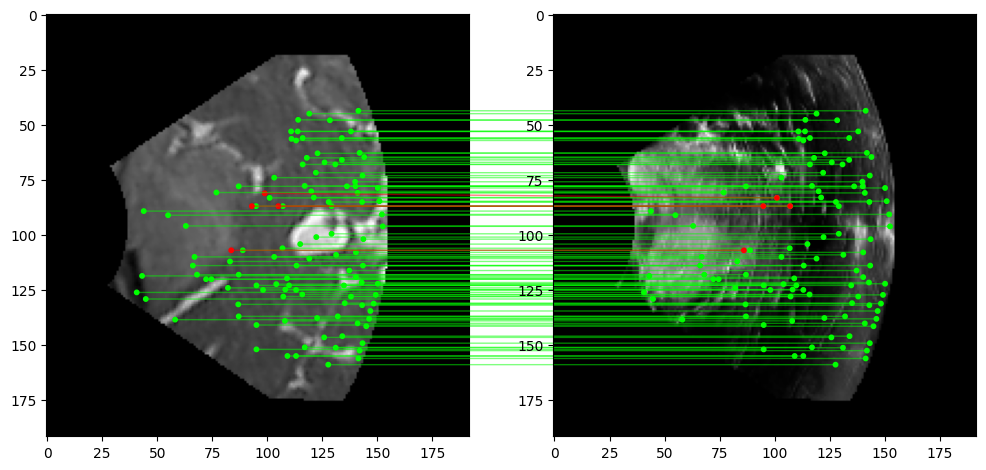

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
from scipy.spatial import ConvexHull

# Function to get embeddings for a list of patches
def get_embeddings(patches):
    embeddings = []
    # print(patches)
    for patch in patches:
        patch_processed = preprocess_image(patch).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            embedding = model.get_embedding(patch_processed)
        embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)


def extract_and_match_patches(image1, kpts1, image2, binary_mask, model, extractor, device, patch_size=64):
    #Not used anymore, doesn't affect results if ratio test is used
    sim_threshold = 0.95
    
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    extractor = SuperPoint(max_num_keypoints=None).eval().to(device)
    
    # feats2 = extractor.extract(image2)
    # feats2 = rbd(feats2)
    # kpts2 = feats2["keypoints"]

    # print(len(kpts2))

    kpts2 = kpts1

    # kpts2 = cluster_keypoints_dbscan(kpts2.cpu().numpy())
    # print(len(kpts2))

    # Extract patches from both images
    # Enforce keypoints on both images
    patches1, kpts1 = extract_patches(image1.cpu().numpy(), kpts1.cpu().numpy(), size=patch_size)
    patches2, kpts2 = extract_patches(image2.cpu().numpy(), kpts2.cpu().numpy(), size=patch_size)

    # Get embeddings for patches from both images
    embeddings1 = get_embeddings(patches1)
    embeddings2 = get_embeddings(patches2)
    
    good_match_distances, bad_match_distances, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2, good_patches1, good_patches2, bad_patches1, bad_patches2 = find_top_matches(patches1, patches2, kpts1, kpts2, embeddings1, embeddings2, sim_threshold)
    # all_matches = len(good_kpts1)
    # print(f"All Matches: {all_matches}")

    # Example: Creating the initial list of matches with similarity scores
    matches = [(i, j, score) for i, j, score in zip(range(len(good_kpts1)), range(len(good_kpts2)), good_match_distances)]
    
    # Filter for one-to-one matches
    one_to_one_matches = filter_one_to_one_matches(matches)
    
    # Extracting the filtered keypoints and their scores
    filtered_good_kpts1 = [good_kpts1[i] for i, _, _ in one_to_one_matches]
    filtered_good_kpts2 = [good_kpts2[j] for _, j, _ in one_to_one_matches]
    filtered_scores = [score for _, _, score in one_to_one_matches]

    # Step 2: Compute the convex hull of these keypoints
    convex_hull = ConvexHull(filtered_good_kpts1)
    # hull_points = good_kpts1_array[convex_hull.vertices]

    # Step 3: Calculate the area of the convex hull
    convex_hull_area = convex_hull.volume

    # Assuming binary_mask is a binary mask where the area of interest is marked as 1 (true) and the rest as 0 (false)
    mask_area = np.sum(binary_mask.cpu().numpy())
    
    # Step 5: Calculate the percentage of the area covered by the convex hull relative to the area defined by the mask
    percentage_area_covered = (convex_hull_area / mask_area) * 100
    
    convex_hull_area, mask_area, percentage_area_covered

    print(f"Convex Hull Area: {convex_hull_area}")
    print(f"Mask Area: {mask_area}")
    print(f"Area Covered: {percentage_area_covered}")

    all_matches = len(filtered_good_kpts1)
    print(f"All Matches: {all_matches}")

    patches1, filtered_good_kpts1 = extract_patches(image1.cpu().numpy(), filtered_good_kpts1, size=patch_size)
    patches2, filtered_good_kpts2 = extract_patches(image2.cpu().numpy(), filtered_good_kpts2, size=patch_size)
    
    # print(f"All Matches (within threshold): {len(filtered_top_matches)}")
    good_good_kpts1, good_good_kpts2, good_good_patches1, good_good_patches2, good_good_distances, bad_good_kpts1, bad_good_kpts2, bad_good_patches1, bad_good_patches2, bad_good_distances, similar_patches_count = extract_good_and_bad_matches(patches1, patches2, filtered_good_kpts1, filtered_good_kpts2, filtered_scores)
    print(f"TPs: {len(good_good_kpts1)}")
    print(f"FPs: {len(bad_good_kpts1)}")
    print(f"TPR: {len(good_good_kpts1)/all_matches*100}%")
    print(f"FPR: {len(bad_good_kpts1)/all_matches*100}%")
    # print(f"Percentage of Good Matches: {(len(good_good_kpts1)/len(good_kpts1))*100}%")
    show_matched_keypoints(image1, image2, good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2)
    return patches1, patches2, kpts1, kpts2, good_good_patches1, good_good_patches2, good_good_kpts1, good_good_kpts2, good_good_distances, bad_good_patches1, bad_good_patches2, bad_good_kpts1, bad_good_kpts2, bad_good_distances

def extract_good_and_bad_matches(good_patches1, good_patches2, good_kpts1, good_kpts2, good_distances, margin=0):
    # Convert keypoints lists to NumPy arrays for efficient computation
    good_kpts1_array = np.array(good_kpts1)
    good_kpts2_array = np.array(good_kpts2)

    # Compute the absolute differences between keypoints
    diff = np.abs(good_kpts1_array - good_kpts2_array)

    # Identify good matches based on the margin
    good_matches_mask = np.all(diff <= margin, axis=1)

    # Split the keypoints, patches, and distances based on the good matches mask
    good_good_kpts1 = good_kpts1_array[good_matches_mask].tolist()
    good_good_kpts2 = good_kpts2_array[good_matches_mask].tolist()
    good_good_patches1 = np.array(good_patches1)[good_matches_mask].tolist()
    good_good_patches2 = np.array(good_patches2)[good_matches_mask].tolist()
    good_good_distances = np.array(good_distances)[good_matches_mask].tolist()

    bad_good_kpts1 = good_kpts1_array[~good_matches_mask].tolist()
    bad_good_kpts2 = good_kpts2_array[~good_matches_mask].tolist()
    bad_good_patches1 = np.array(good_patches1)[~good_matches_mask].tolist()
    bad_good_patches2 = np.array(good_patches2)[~good_matches_mask].tolist()
    bad_good_distances = np.array(good_distances)[~good_matches_mask].tolist()

    count = np.sum(good_matches_mask)

    # print(type(good_good_patches1))

    return good_good_kpts1, good_good_kpts2, good_good_patches1, good_good_patches2, good_good_distances, bad_good_kpts1, bad_good_kpts2, bad_good_patches1, bad_good_patches2, bad_good_distances, count


def preprocess_image(image):
    # Implement any preprocessing steps (resizing, normalization, etc.)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts image to PyTorch tensor in CxHxW format
        transforms.Normalize(mean=(0), std=(1))  # Normalize the image
    ])
    image = transform(image).to(device)
    return image

long_side = 192

image1 = load_path_for_pytorch("data/mr_us/Case096/t2/035.png", long_side,force_scale=True).to(device)
image2 = load_path_for_pytorch("data/mr_us/Case096/invariance/invariance_test/cet1/035-cet1_0.3.png", long_side,force_scale=True).to(device)

masked_image1, binary_mask = isolate_green_and_mask_image(images/"mr_us/Case096/t2/035.png", images/"mr_us/Case096/us_mask.png", long_side, device)

# plt.imshow(masked_image1.cpu().numpy().transpose(1,2,0))

extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
# image1 = image1.to(device)
feats1 = extractor.extract(masked_image1)
feats1 = rbd(feats1)
kpts1 = feats1["keypoints"]

patches1, patches2, kpts1, kpts2, good_patches1, good_patches2, good_kpts1, good_kpts2, good_distances, bad_patches1, bad_patches2, bad_kpts1, bad_kpts2, bad_distances = extract_and_match_patches(image1, kpts1, image2, binary_mask, model, extractor, device)

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2


def extract_and_match_patches_all(image1, kpts1, image2, model, extractor, device, patch_size=64):
    #Not used anymore, doesn't affect results if ratio test is used
    sim_threshold = 0.95
    
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    kpts2 = kpts1
    
    # Enforce keypoints on both images
    patches1, kpts1 = extract_patches(image1.cpu().numpy(), kpts1.cpu().numpy(), size=patch_size)
    patches2, kpts2 = extract_patches(image2.cpu().numpy(), kpts2.cpu().numpy(), size=patch_size)

    # Get embeddings for patches from both images
    embeddings1 = get_embeddings(patches1)
    embeddings2 = get_embeddings(patches2)
    
    good_match_distances, bad_match_distances, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2, good_patches1, good_patches2, bad_patches1, bad_patches2 = find_top_matches(patches1, patches2, kpts1, kpts2, embeddings1, embeddings2, sim_threshold)

    # Example: Creating the initial list of matches with similarity scores
    matches = [(i, j, score) for i, j, score in zip(range(len(good_kpts1)), range(len(good_kpts2)), good_match_distances)]
    
    # Filter for one-to-one matches
    one_to_one_matches = filter_one_to_one_matches(matches)
    
    # Extracting the filtered keypoints and their scores
    filtered_good_kpts1 = [good_kpts1[i] for i, _, _ in one_to_one_matches]
    filtered_good_kpts2 = [good_kpts2[j] for _, j, _ in one_to_one_matches]
    filtered_scores = [score for _, _, score in one_to_one_matches]

    all_matches = len(filtered_good_kpts1)
    print(f"All Matches: {all_matches}")

    patches1, filtered_good_kpts1 = extract_patches(image1.cpu().numpy(), filtered_good_kpts1, size=patch_size)
    patches2, filtered_good_kpts2 = extract_patches(image2.cpu().numpy(), filtered_good_kpts2, size=patch_size)
    
    # print(f"All Matches (within threshold): {len(filtered_top_matches)}")
    good_good_kpts1, good_good_kpts2, good_good_patches1, good_good_patches2, good_good_distances, bad_good_kpts1, bad_good_kpts2, bad_good_patches1, bad_good_patches2, bad_good_distances, similar_patches_count = extract_good_and_bad_matches(patches1, patches2, filtered_good_kpts1, filtered_good_kpts2, filtered_scores)
    print(f"TPs: {len(good_good_kpts1)}")
    print(f"FPs: {len(bad_good_kpts1)}")
    print(f"TPR: {len(good_good_kpts1)/all_matches*100}%")
    print(f"FPR: {len(bad_good_kpts1)/all_matches*100}%")
    return all_matches, good_good_kpts1, good_good_kpts2, len(good_good_kpts1)

In [22]:
import numpy as np
import json

anchor_keypoints = {}
matched_anchor_keypoints = {}
style_keypoints = {}

max_matched_style = None
max_matched_count = 0

modalities = ['cet1', 'flair', 't2_flair']
temps = ['0.3', '0.5', '0.7', '1']

total_variations = 12
i = 35


for modality in modalities:
    for temp in temps:
        slice_num = f"{i:03}"  # Format the slice number with leading zeros
        variation = f"{modality}_{temp}"
        t2_path = f"data/mr_us/Case096/t2/{slice_num}.png"
        us_path = f"data/mr_us/Case096/invariance/invariance_test/{modality}/{slice_num}-{variation}.png"
        
        # Load images (modify your load_path_for_pytorch function accordingly)
        image1 = load_path_for_pytorch(t2_path, long_side, force_scale=True).to(device)
        image2 = load_path_for_pytorch(us_path, long_side, force_scale=True).to(device)
        
        # You might need to adjust how keypoints are loaded and processed based on your specific setup
        masked_image1, binary_mask = isolate_green_and_mask_image(images/f"mr_us/Case096/t2/{slice_num}.png", images/"mr_us/Case096/us_mask.png", long_side, device)
    
        extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
        # image1 = image1.to(device)
        feats1 = extractor.extract(masked_image1)
        feats1 = rbd(feats1)
        kpts1 = feats1["keypoints"]
    
        print(f"Slice Number: {i}")
        all_matches, kpts1, kpts2, precision = extract_and_match_patches_all(image1, kpts1, image2, model, extractor, device)
    
        matched_anchor_keypoints[variation] = kpts1
        style_keypoints[variation] = kpts2

        # Check if current style has the highest number of matched keypoints
        if len(kpts1) > max_matched_count:
            max_matched_count = len(kpts1)
            max_matched_style = variation

        print(f"Style with most matches: {max_matched_style}, Matches: {max_matched_count}")

/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Slice Number: 35
All Matches: 112
TPs: 108
FPs: 4
TPR: 96.42857142857143%
FPR: 3.571428571428571%
Style with most matches: cet1_0.3, Matches: 108
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 118
TPs: 114
FPs: 4
TPR: 96.61016949152543%
FPR: 3.389830508474576%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 112
TPs: 108
FPs: 4
TPR: 96.42857142857143%
FPR: 3.571428571428571%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 109
TPs: 102
FPs: 7
TPR: 93.57798165137615%
FPR: 6.422018348623854%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 88
TPs: 87
FPs: 1
TPR: 98.86363636363636%
FPR: 1.1363636363636365%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 81
TPs: 80
FPs: 1
TPR: 98.76543209876543%
FPR: 1.2345679012345678%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 83
TPs: 83
FPs: 0
TPR: 100.0%
FPR: 0.0%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 87
TPs: 85
FPs: 2
TPR: 97.70114942528735%
FPR: 2.2988505747126435%
Style with most matches: cet1_0.5, Matches: 114
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 121
TPs: 120
FPs: 1
TPR: 99.17355371900827%
FPR: 0.8264462809917356%
Style with most matches: t2_flair_0.3, Matches: 120
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 122
TPs: 121
FPs: 1
TPR: 99.18032786885246%
FPR: 0.819672131147541%
Style with most matches: t2_flair_0.5, Matches: 121
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 123
TPs: 121
FPs: 2
TPR: 98.3739837398374%
FPR: 1.6260162601626018%
Style with most matches: t2_flair_0.5, Matches: 121
Slice Number: 35


/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


All Matches: 118
TPs: 115
FPs: 3
TPR: 97.45762711864407%
FPR: 2.5423728813559325%
Style with most matches: t2_flair_0.5, Matches: 121


In [23]:
# import os

# def match_with_all_styles(anchor_image, styles_folder, model, extractor, device):
#     style_keypoints = {}  # Dictionary to store good keypoints for each style
#     total_good_keypoints = 0

#     for style_image_name in os.listdir(styles_folder):
#         style_image_path = os.path.join(styles_folder, style_image_name)
#         style_image = load_image(style_image_path)
        
#         _, _, good_good_kpts1, good_good_kpts2, good_good_distances, _, _, _, _, _ = extract_and_match_patches(
#             anchor_image, style_image, model, extractor, device
#         )

#         anchor_keypoints[style_image_name] = good_good_kpts1
#         style_keypoints[style_image_name] = good_good_kpts2
#         total_good_keypoints += len(good_good_distances)

#         # Calculate and print percentage of good_good_keypoints
#         print(f"Percentage of good_good_keypoints in {style_image_name}: {(len(good_good_distances) / len(style_keypoints[style_image_name])) * 100}%")

#     # Compare keypoints across all styles and count consistent keypoints
#     consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints)

#     return style_keypoints, consistent_keypoints

def find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=5):
    # Initialize a list to store keypoints present in all images
    consistent_keypoints = []

    # Compare keypoints across all styles
    for kp in style_keypoints[list(style_keypoints.keys())[0]]:
        is_consistent = True
        for style, keypoints in style_keypoints.items():
            if not is_keypoint_in_list(kp, keypoints, margin):
                is_consistent = False
                break

        if is_consistent:
            consistent_keypoints.append(kp)

    return consistent_keypoints

def is_keypoint_in_list(keypoint, keypoints_list, margin):
    for kp in keypoints_list:
        if abs(kp[0] - keypoint[0]) <= margin and abs(kp[1] - keypoint[1]) <= margin:
            return True
    return False

# # Example usage
# anchor_image = load_image('data/0_output_mr.png')
# styles_folder = 'data/vrmr_guided/0_output_mr'
# style_keypoints, consistent_keypoints = match_with_all_styles(anchor_image, styles_folder, model, extractor, device)

extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
i = 35
slice_num = f"{i:03}"
t2_path = f"data/mr_us/Case067/t2/{slice_num}.png"
image1 = load_path_for_pytorch(t2_path, long_side, force_scale=True).to(device)
feats1 = extractor.extract(masked_image1)
feats1 = rbd(feats1)
anchor_keypoints = feats1["keypoints"]

consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints)

/tmp/ipykernel_17648/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


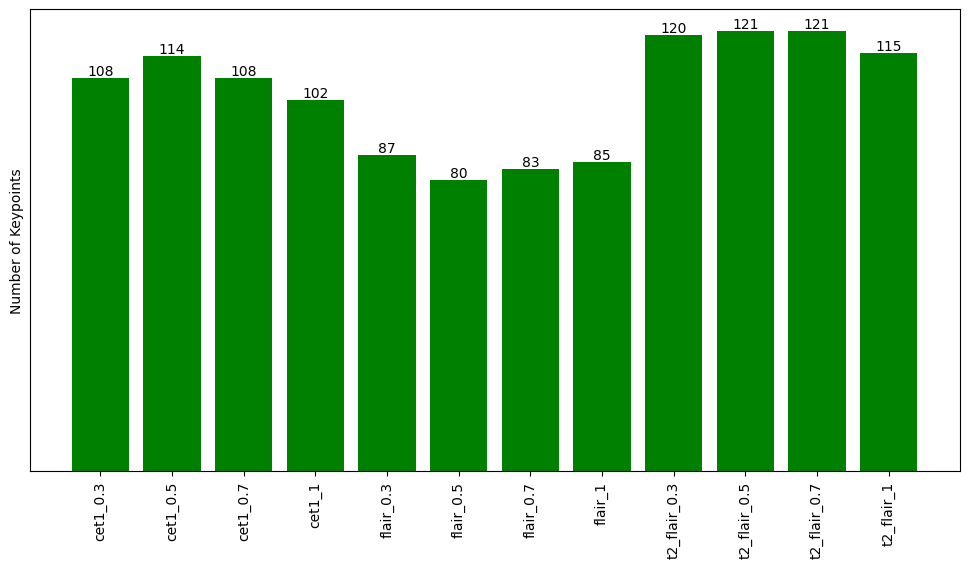

In [24]:
import matplotlib.pyplot as plt

def plot_keypoints_bar_chart(keypoints_dict):
    # Extracting style names and counts of keypoints
    styles = list(keypoints_dict.keys())
    counts = [len(keypoints_dict[style]) for style in styles]

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(styles, counts, color='green')

    # Adding count labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    # plt.xlabel('Style')
    plt.ylabel('Number of Keypoints')
    # plt.title('Keypoint Counts per Style')
    plt.yticks([])
    plt.xticks(rotation=90)
    # plt.savefig("keypoints_per_variation.png")
    plt.show()

plot_keypoints_bar_chart(style_keypoints)


In [25]:
import numpy as np

def is_keypoint_in_list(style_keypoints, r_kp, margin):
    style_kps_array = np.array(style_keypoints)

    # Compute the absolute difference
    diff = np.abs(style_kps_array - r_kp.cpu().numpy())

    # Check if any keypoint is within the margin
    return np.any(np.all(diff <= margin, axis=1))

def find_consistent_keypoints(reference_keypoints, all_style_keypoints, margin=0):
    consistent_keypoints = []

    for r_kp in reference_keypoints:
        if all(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values()):
            consistent_keypoints.append(r_kp)
    
    return consistent_keypoints


# Use the keypoints from the most matched style to check consistency over all styles
consistent_keypoints = find_consistent_keypoints(anchor_keypoints, style_keypoints, margin=0)

print("Number of consistent keypoints across all styles:", len(consistent_keypoints))

Number of consistent keypoints across all styles: 73


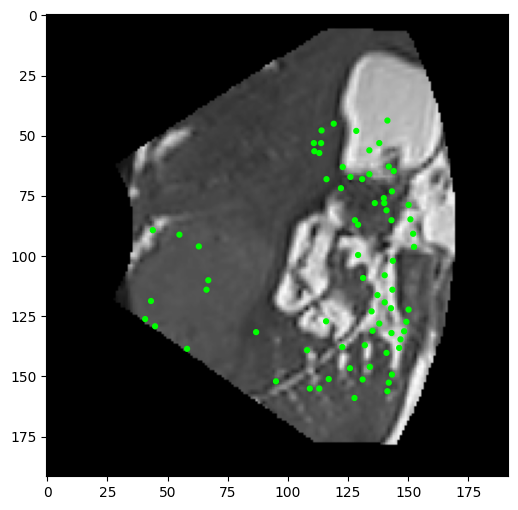

In [26]:
def match_consistent_keypoints(image1, consistent_keypoints, patch_size=64):
    # Preprocess and extract patches from both images
    image1 = image1.to(device)

    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)

    # Display original images
    
    axs.imshow(image1_np)

    # Overlay patches on images
    for i in range(len(consistent_keypoints)):
        x1, y1 = consistent_keypoints[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs.add_patch(cir1)

    plt.show()

match_consistent_keypoints(image1, consistent_keypoints)

In [125]:
# def get_similarities_of_consistent_points(anchor_image, styles_folder, consistent_points, device):

#     # Process the anchor image
#     anchor_image = anchor_image.to(device)
#     patches1, kpts1 = extract_patches(anchor_image.cpu().numpy(), consistent_points, size=patch_size)
#     embeddings1 = get_embeddings(patches1)
#     embeddings1_array = np.array(embeddings1)
#     embeddings1_array = embeddings1_array / np.linalg.norm(embeddings1_array, axis=1, keepdims=True)

#     style_similarities = {}
    
#     for style_image_name in os.listdir(styles_folder):
#         style_image_path = os.path.join(styles_folder, style_image_name)
#         style_image = load_image(style_image_path)

#         style_image = style_image.to(device)
#         patches2, kpts2 = extract_patches(style_image.cpu().numpy(), consistent_points, size=patch_size)
#         embeddings2 = get_embeddings(patches2)
#         embeddings2_array = np.array(embeddings2)
#         embeddings2_array = embeddings2_array / np.linalg.norm(embeddings2_array, axis=1, keepdims=True)

#         # Computer pairwise cos distance
#         similarities = cosine_similarity(embeddings1_array, embeddings2_array)

#         # Compute cosine similarity for the corresponding points
#         similarities = np.diag(cosine_similarity(embeddings1_array, embeddings2_array))
#         style_similarities[style_image_name] = similarities

#     return style_similarities

# # Example usage
# anchor_image = load_image('data/0_output_mr.png')
# styles_folder = 'data/vrmr_guided/testset/0_output_mr'
# style_similarities = get_similarities_of_consistent_points(anchor_image, styles_folder, consistent_keypoints, device)

In [126]:
# def plot_style_similarities(style_similarities, consistent_points):
#     # Prepare data for plotting
#     styles = list(style_similarities.keys())
#     similarities = [style_similarities[style] for style in styles]
        
#     # Plotting each point's distance across styles
#     for i in range(len(similarities[:2])):
#         point_x, point_y = consistent_points[i]
#         plt.plot(styles, [sim[i] for sim in similarities], label=f'Point ({point_x}, {point_y})')

#     plt.xlabel('Style Images')
#     plt.ylabel('Similarity')
#     plt.title('Similarities of Consistent Points Across Styles')
#     plt.legend()
#     plt.xticks(rotation=90)

#     plt.ylim(0,1)
    
#     # plt.tight_layout()
#     plt.savefig("dist_cos_ours.png")
#     plt.show()

# plot_style_similarities(style_similarities, consistent_keypoints)

In [127]:
# import numpy as np

# mean_similarities = {}
# std_similarities = {}

# for point_index in range(len(consistent_keypoints)):
#     point_similarities = np.array([style_similarities[style][point_index] for style in style_similarities.keys()])
#     mean_similarities[point_index] = np.mean(point_similarities)
#     std_similarities[point_index] = np.std(point_similarities)

# selected_points = [0, 1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]  # Replace with indices of points you want to plot
# selected_means = [mean_similarities[i] for i in selected_points]
# selected_stds = [std_similarities[i] for i in selected_points]

# plt.bar(range(len(selected_points)), selected_means, yerr=selected_stds, capsize=5)
# plt.xlabel('Point Index')
# plt.ylabel('Mean Distance')
# plt.title('Mean and Standard Deviation of Distances for Selected Points')
# # plt.xticks(range(len(selected_points)), [f'Point {i}' for i in selected_points])

# plt.ylim(0,1)
# plt.savefig("stdmean_cos_ours.png")

# plt.show()

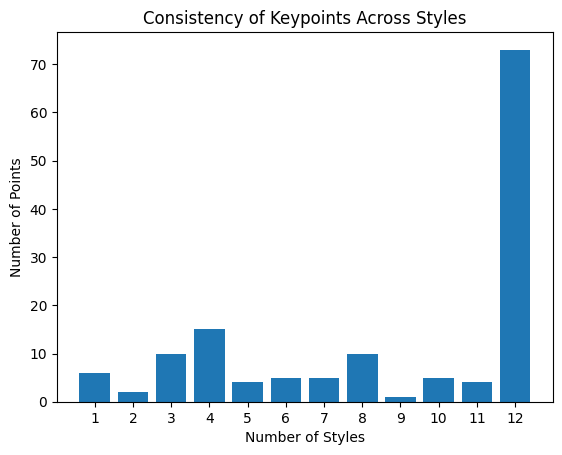

In [27]:
import matplotlib.pyplot as plt
import json

def find_consistency_counts(reference_keypoints, all_style_keypoints, margin=0):
    consistency_counts = {}

    for r_kp in reference_keypoints:
        count = sum(is_keypoint_in_list(style_kps, r_kp, margin) for style_kps in all_style_keypoints.values())
        if count > 0:
            count_int = int(count)
            consistency_counts.setdefault(count_int, 0)
            consistency_counts[count_int] += 1

    return consistency_counts

# Calculate consistency counts
consistency_counts = find_consistency_counts(anchor_keypoints, style_keypoints, margin=0)

# Save the consistency_counts to a JSON file
file_path = 'cos_ours_consistency_counts_case067.json'
with open(file_path, 'w') as file:
    json.dump(consistency_counts, file)

# Plotting the consistency counts
style_counts = list(consistency_counts.keys())
num_points = list(consistency_counts.values())

plt.bar(style_counts, num_points)
plt.xlabel('Number of Styles')
plt.ylabel('Number of Points')
plt.title('Consistency of Keypoints Across Styles')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('cos_ours_consistency_kp_count.png')
plt.show()

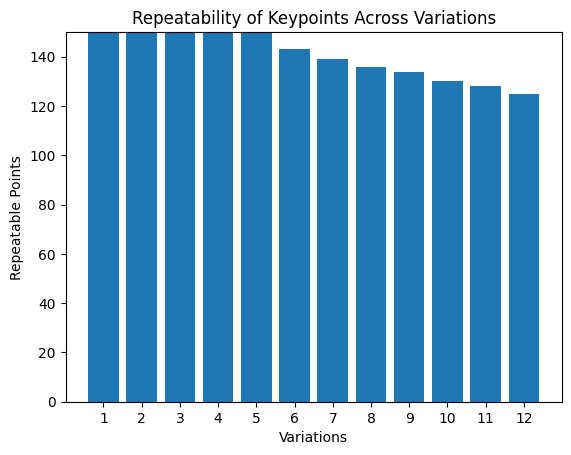

In [129]:
def aggregate_counts(consistency_counts):
    aggregated_counts = {}
    max_count = max(consistency_counts.keys())
    min_count = min(consistency_counts.keys())

    cumulative_count = 0
    for count in range(max_count, min_count - 1, -1):
        cumulative_count += consistency_counts.get(count, 0)
        aggregated_counts[count] = cumulative_count

    return aggregated_counts

# Aggregate consistency counts
aggregated_counts = aggregate_counts(consistency_counts)

file_path = 'cos_ours_consistency_counts_case067.json'
with open(file_path, 'w') as file:
    json.dump(aggregated_counts, file)

# Prepare the data for plotting
min_count = min(aggregated_counts.keys())
max_count = max(aggregated_counts.keys())
style_counts = list(range(min_count, max_count + 1))
num_points = [aggregated_counts.get(count, aggregated_counts[min_count]) for count in style_counts]

plt.bar(style_counts, num_points)
plt.xlabel('Variations')
plt.ylabel('Repeatable Points')
plt.ylim(0,150)
plt.title('Repeatability of Keypoints Across Variations')
plt.xticks(style_counts)  # Ensure that all style counts are shown as x-ticks
plt.savefig('cos_ours_aggr_consistency_kp_count_bar.png')
plt.show()

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from torch.nn.functional import cosine_similarity

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True).features

# Function to preprocess the image
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(img_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Function to calculate the Gram matrix
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# Function to extract feature maps and compute Gram matrix
def get_gram_matrix(image_path):
    image = preprocess_image(image_path)
    features = vgg(image)
    return gram_matrix(features)

# URLs of two images
image1_path = "data/0_output_mr.png"
image2_path = "data/vrmr_guided/0_output_mr/0_output_mr.png_style01.png_weight_1.0.png"

# Calculate Gram matrices
gram_matrix1 = get_gram_matrix(image1_path)
gram_matrix2 = get_gram_matrix(image2_path)

# Compare the Gram matrices using cosine similarity
similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix2.view(1, -1))

similarity.item()

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def get_keypoints(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, _ = orb.detectAndCompute(gray, None)
    return len(keypoints)

# Directory containing stylized images
image_directory = "data/vrmr_guided/0_output_mr"

# Initialize lists to store results
gram_scores = []
keypoint_counts = []

# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_name)

    # Skip if it's not an image
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # Calculate Gram matrix and similarity score
    gram_matrix_stylized = get_gram_matrix(image_path)
    similarity = cosine_similarity(gram_matrix1.view(1, -1), gram_matrix_stylized.view(1, -1))
    gram_scores.append(similarity.item())

    # Get the number of keypoints
    # keypoint_count = get_keypoints(image_path)
    keypoint_count = len(style_keypoints[image_name])
    keypoint_counts.append(keypoint_count)

# Plotting
plt.scatter(gram_scores, keypoint_counts)
plt.xlabel('Gram Score')
plt.ylabel('Number of Keypoints')
plt.yticks([0,400,800,1200,1600,2000])
plt.title('Gram Score vs Keypoints in Stylized Images')
plt.savefig('cos_ours_gram_score_keypoints.png')
plt.show()